In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
hj23_lr = pd.read_csv("GeneratedFiles/Databases/hj23_lr.csv", sep=';', encoding='ISO-8859-1')
hj23_rf = pd.read_csv("GeneratedFiles/Databases/hj23_rf.csv", sep=';', encoding='ISO-8859-1')
hj23_pls = pd.read_csv("GeneratedFiles/Databases/hj23_pls.csv", sep=';', encoding='ISO-8859-1')

* Cargo solo las variables seleccionadas como importantes

In [3]:
lr_important=pd.read_csv("GeneratedFiles/ImportantVariables/lr_important.csv", sep=',', encoding='ISO-8859-1')
list_lr_important=list(lr_important['colummn'].values)
list_lr_important.append('lactate_label')

rf_important=pd.read_csv("GeneratedFiles/ImportantVariables/rf_important.csv", sep=',', encoding='ISO-8859-1')
list_rf_important=list(rf_important['colummn'].values)
list_rf_important.append('lactate_label')

pls_important=pd.read_csv("GeneratedFiles/ImportantVariables/pls_important.csv", sep=',', encoding='ISO-8859-1')
list_pls_important=list(pls_important['colummn'].values)
list_pls_important.append('lactate_label')

In [4]:
list_lr_important.remove('calcium')
hj23_lr = hj23_lr[list_lr_important]

list_rf_important.remove('calcium')
hj23_rf = hj23_rf[list_rf_important]

hj23_pls = hj23_pls[list_pls_important]

# Logistic Regression with CV
***

- hj23

In [5]:
print("--------------------------")

print("Logistic Regression at hj23 with features selected")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


--------------------------
Logistic Regression at hj23 with features selected


In [6]:
from sklearn.model_selection import cross_validate


hj23_lr_2 = hj23_lr.copy()
categorical=hj23_lr[list(hj23_lr.columns[hj23_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_lr[col] = np.where(hj23_lr[col]=='Yes',1,0)

hj23_lr['lactate_label'] = np.where(hj23_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = hj23_lr['lactate_label']
x_lr= hj23_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
0  0.971429
3  0.882353
4  0.852941
1  0.800000
2  0.735294
roc 0.9869281045751633
recall 0.9444444444444444


Importance of features for hj23 after CV


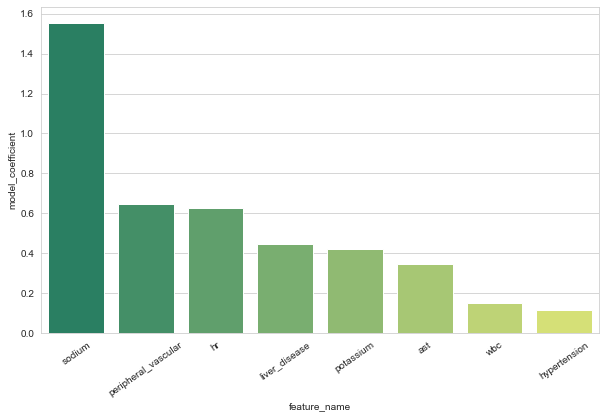

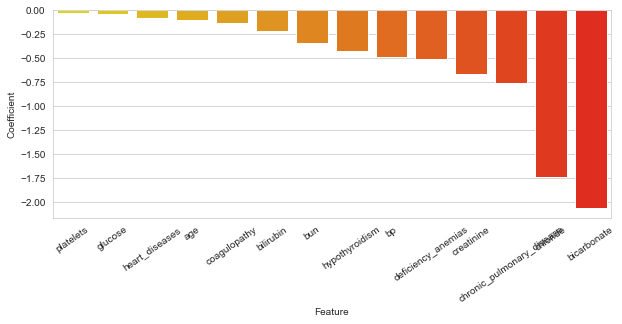

In [7]:
print("Importance of features for hj23 after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_hj23 = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_hj23 = logReg_coeff_lr_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_hj23.head(sum(logReg_coeff_lr_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_hj23.tail(sum(logReg_coeff_lr_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [8]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '10']
 ['FP' '9']
 ['TN' '73']
 ['TP' '80']]


In [9]:
logReg_coeff_lr_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_lr_hj23_2.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- hj23

In [10]:
print("--------------------------")

print("Random Forest at hj23 for feature selection")


--------------------------
Random Forest at hj23 for feature selection


Score for CV
      score
0  0.800000
1  0.771429
2  0.764706
3  0.705882
4  0.705882
roc 0.8986928104575163
recall 0.7777777777777778


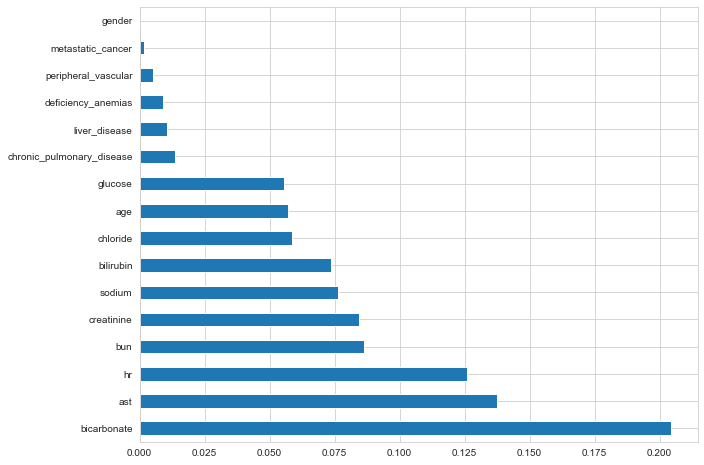

In [11]:
from sklearn.model_selection import cross_validate
hj23_rf_2 = hj23_rf.copy()

hj23_rf_3 = hj23_rf_2.copy()
categorical=hj23_rf_2[list(hj23_rf_2.columns[hj23_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)

hj23_rf_2['gender'] = np.where(hj23_rf_2['gender']=='M',1,0)

for col in categorical:
    hj23_rf_2[col] = np.where(hj23_rf_2[col]=='Yes',1,0)

hj23_rf_2['lactate_label'] = np.where(hj23_rf_2['lactate_label'] == 'high',1,0)

rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10, n_jobs=-1)
y_rf = hj23_rf_2['lactate_label']
x_rf= hj23_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

In [12]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(hj23_rf_2.loc[hj23_rf_2['lactate_label']==1][var] == 1)
        low = sum(hj23_rf_2.loc[hj23_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.mean(hj23_rf_2.loc[hj23_rf_2['lactate_label']==1][var])
        low = np.mean(hj23_rf_2.loc[hj23_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for hj23 after CV


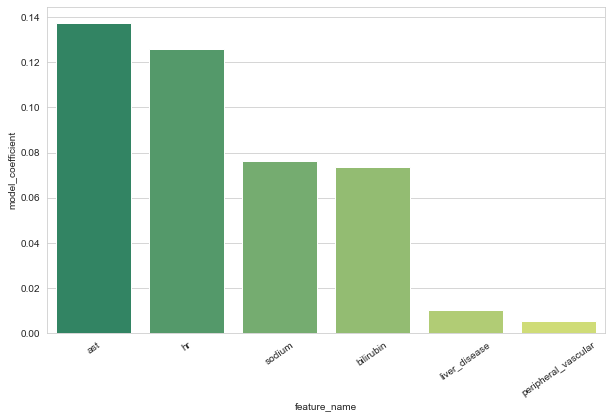

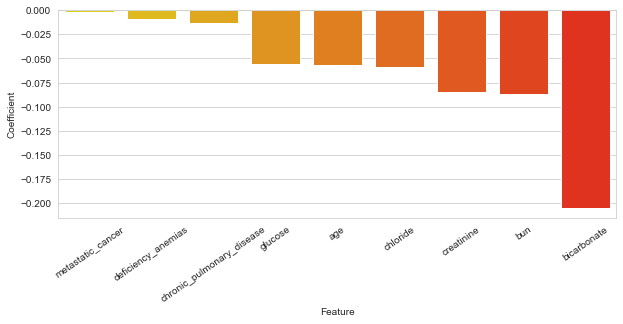

In [13]:
print("Importance of features for hj23 after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_hj23 = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_hj23 = logReg_coeff_rf_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_hj23.head(sum(logReg_coeff_rf_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_hj23.tail(sum(logReg_coeff_rf_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [14]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '4']
 ['FP' '3']
 ['TN' '79']
 ['TP' '86']]


In [15]:
logReg_coeff_rf_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_rf_hj23_2.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [16]:
print("--------------------------")

print("Orthogonal PLS at hj23 for feature selection")


categorical=hj23_pls[list(hj23_pls.columns[hj23_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_pls[col] = np.where(hj23_pls[col]=='Yes',1,0)

hj23_pls['lactate_label'] = np.where(hj23_pls['lactate_label'] == 'high',1,0)

y_lr = hj23_pls['lactate_label']
x_lr= hj23_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at hj23 for feature selection


In [17]:

from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

x_pls = x_lr
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(hj23_pls):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    predict_auc=np.where(predict>=0.5,1,0)
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)

print(accuracy_pls_componentes)
print(roc_pls_componentes)

scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))


[0.8857142857142857, 0.7428571428571429, 0.7647058823529411, 0.8529411764705882, 0.8823529411764706]
[0.9766666666666667, 0.8627450980392156, 0.888888888888889, 0.9, 0.9649122807017544]
Score for CV
      score
0  0.885714
4  0.882353
3  0.852941
2  0.764706
1  0.742857
roc 0.9766666666666667
recall 0.85


Importance of features for hj23 after CV


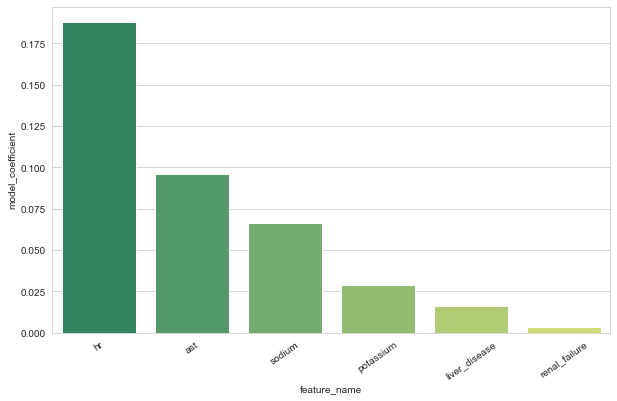

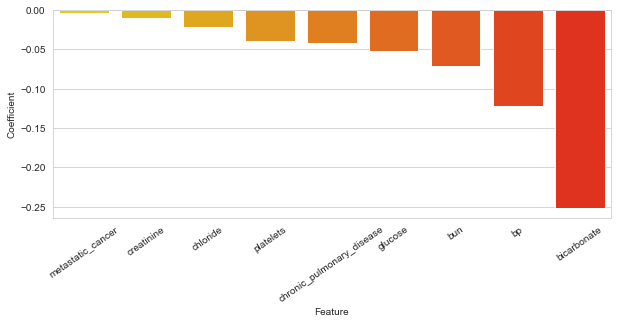

In [18]:
print("Importance of features for hj23 after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_hj23 = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_hj23 = logReg_coeff_pls_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_hj23.head(sum(logReg_coeff_pls_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_hj23.tail(sum(logReg_coeff_pls_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [19]:
logReg_coeff_pls_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_pls_hj23_2.csv', sep=';', header = False, index=False)